# Image Classification using tf.keras



In [1]:
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

TensorFlow 2.x selected.


# Importing Packages

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [0]:
import os
import matplotlib.pyplot as plt
import numpy as np
import glob
import shutil


In [0]:
import logging
logger =tf.get_logger()
logger.setLevel(logging.ERROR)

## Data Loading
In order to build our image classifier, we can begin by downloading the flowers dataset. We first need to download the archive version of the dataset and after the download we are storing it to "/tmp/" directory.

In [5]:
_URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

zip_file = tf.keras.utils.get_file(origin=_URL,
                                   fname="flower_photos.tgz",
                                   extract=True)

base_dir = os.path.join(os.path.dirname(zip_file), 'flower_photos')

228818944/228813984 [==============================] - 2s 0us/step


In [0]:
classes = ['roses', 'daisy', 'dandelion', 'sunflowers', 'tulips']

In [7]:
for cl in classes:
  img_path = os.path.join(base_dir, cl)
  images = glob.glob(img_path + '/*.jpg')
  print("{}: {} Images".format(cl, len(images)))
  train, val = images[:round(len(images)*0.8)], images[round(len(images)*0.8):]

  for t in train:
    if not os.path.exists(os.path.join(base_dir, 'train', cl)):
      os.makedirs(os.path.join(base_dir, 'train', cl))
    shutil.move(t, os.path.join(base_dir, 'train', cl))

  for v in val:
    if not os.path.exists(os.path.join(base_dir, 'val', cl)):
      os.makedirs(os.path.join(base_dir, 'val', cl))
    shutil.move(v, os.path.join(base_dir, 'val', cl))

roses: 641 Images
daisy: 633 Images
dandelion: 898 Images
sunflowers: 699 Images
tulips: 799 Images


In [0]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

## Data Augmentation

In [0]:
batch_size = 100
IMG_SIZE = 150

### Put It All Together - Data Augmentation

In the cell below, use ImageDataGenerator to create a transformation that rescales the images by 255 and that applies:

- random 45 degree rotation
- random zoom of up to 50%
- random horizontal flip
- width shift of 0.15
- height shift of 0.15

Then use the `.flow_from_directory` method to apply the above transformation to the images in our training set. Make sure you indicate the batch size, the path to the directory of the training images, the target size for the images, to shuffle the images, and to set the class mode to `sparse`.

In [10]:
image_gen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=45,
      width_shift_range=0.15,
      height_shift_range=0.15,
      #shear_range=0.2,
      zoom_range=0.5,
      horizontal_flip=True,
      )

train_data_gen  = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_SIZE,IMG_SIZE),
                                                     class_mode='sparse')

Found 2935 images belonging to 5 classes.


Let's visualize how a single image would look like 5 different times, when we pass these augmentations randomly to our dataset. 

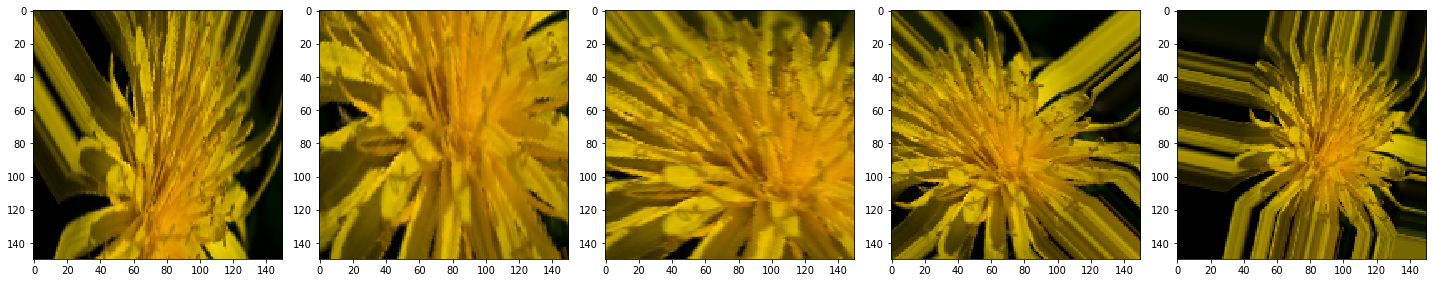

In [11]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Creating a Data Generator for the Validation Set

Generally, we only apply data augmentation to our training examples. So, in the cell below, use ImageDataGenerator to create a transformation that only rescales the images by 255. Then use the `.flow_from_directory` method to apply the above transformation to the images in our validation set. Make sure you indicate the batch size, the path to the directory of the validation images, the target size for the images, and to set the class mode to `sparse`. Remember that it is not necessary to shuffle the images in the validation set. 

In [12]:
validation_image_generator = ImageDataGenerator(rescale=1./255)  # Generator for our validation data
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory= val_dir,
                                                              target_size= (IMG_SIZE,IMG_SIZE), #(150,150)
                                                              shuffle= False,
                                                              class_mode='binary')

Found 735 images belonging to 5 classes.


## Create the CNN

In the cell below, create a convolutional neural network that consists of 3 convolution blocks. Each convolutional block contains a `Conv2D` layer followed by a max pool layer. The first convolutional block should have 16 filters, the second one should have 32 filters, and the third one should have 64 filters. All convolutional filters should be 3 x 3. All max pool layers should have a `pool_size` of `(2, 2)`.

After the 3 convolutional blocks you should have a flatten layer followed by a fully connected layer with 512 units. The CNN should output class probabilities based on 5 classes which is done by the **softmax** activation function. All other layers should use a **relu** activation function. You should also add Dropout layers with a probability of 20%, where appropriate. 

In [0]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

   
    tf.keras.layers.Flatten(),
     tf.keras.layers.Dropout(0.2), ## Setting the dropout probability to 20%

    tf.keras.layers.Dense(512, activation='relu'),
     tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(5, activation='softmax')
])

## Compile the Model

In the cell below, compile your model using the ADAM optimizer, the sparse cross entropy function as a loss function. We would also like to look at training and validation accuracy on each epoch as we train our network, so make sure you also pass the metrics argument.

In [0]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Model Summary

In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 18496)            

## Training the model

In [20]:
%%time
EPOCHS = 80
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch= int(np.ceil(train_data_gen.n / float(batch_size))),
    epochs= EPOCHS,
    validation_data = val_data_gen,
    validation_steps= int(np.ceil(val_data_gen.n/ float(batch_size)))
)

Train for 30 steps, validate for 8 steps
Epoch 1/80
30/30 [==============================] - 26s 878ms/step - loss: 1.7590 - accuracy: 0.2818 - val_loss: 1.3591 - val_accuracy: 0.4014
Epoch 2/80
30/30 [==============================] - 22s 747ms/step - loss: 1.2735 - accuracy: 0.4497 - val_loss: 1.2610 - val_accuracy: 0.4966
Epoch 3/80
30/30 [==============================] - 23s 769ms/step - loss: 1.1334 - accuracy: 0.5325 - val_loss: 1.0999 - val_accuracy: 0.5673
Epoch 4/80
30/30 [==============================] - 23s 766ms/step - loss: 1.0745 - accuracy: 0.5857 - val_loss: 1.0066 - val_accuracy: 0.5932
Epoch 5/80
30/30 [==============================] - 23s 759ms/step - loss: 0.9985 - accuracy: 0.6041 - val_loss: 0.9678 - val_accuracy: 0.6177
Epoch 6/80
30/30 [==============================] - 22s 742ms/step - loss: 0.9761 - accuracy: 0.6157 - val_loss: 1.0695 - val_accuracy: 0.5837
Epoch 7/80
30/30 [==============================] - 23s 756ms/step - loss: 0.9582 - accuracy: 0.6245 

## Visaulizing the results of the training 

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

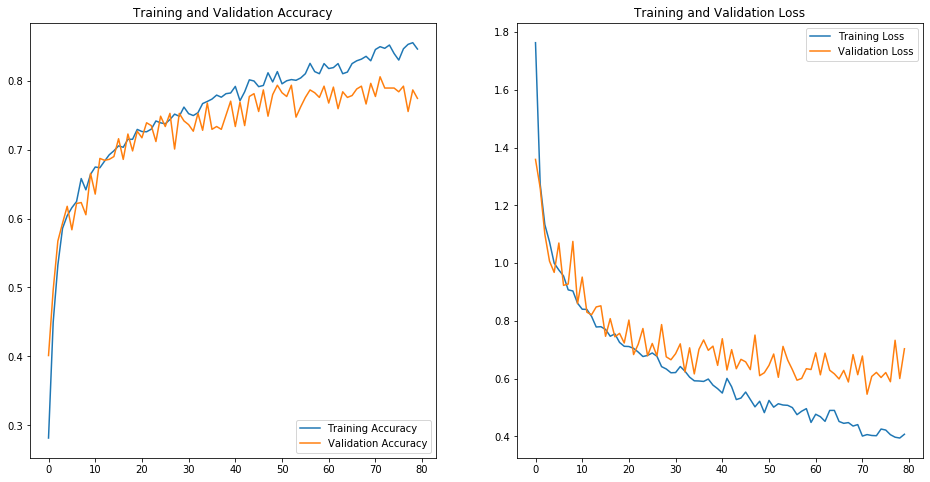

In [22]:
plt.figure(figsize=(16, 8))
# figure 1 Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# figure 2 Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./foo.png')
plt.show()